In [74]:
GOA_LATITUDE = 15.2993
GOA_LONGITUDE =74.1240
print('The geograpical coordinates of Goa are {}, {}.'.format(GOA_LATITUDE, GOA_LONGITUDE))

The geograpical coordinates of Goa are 15.2993, 74.124.


In [75]:

import folium

goa_map = folium.Map(location = [GOA_LATITUDE, GOA_LONGITUDE], zoom_start = 13)
folium.Marker([GOA_LATITUDE, GOA_LONGITUDE]).add_to(goa_map)
goa_map.save("Goa Map.html")
goa_map

In [76]:
FOURSQUARE_CLIENT_ID = 'GUY32TDDWKMZ3YRQCQKTTVQHTSGSV3GVMBG5VRQAMWKCFHSA'
FOURSQUARE_CLIENT_SECRET = '4VKNRTFBOIAQHG5VAQBZ41RAE1UWL2BMT5JAKGSNYDKMSO4E'
RADIUS = 40000 # 40 Km
NO_OF_VENUES = 100
VERSION = '20200304' # Current date

In [77]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        GOA_LATITUDE, 
                                                                        GOA_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 100 venues fetched within a total radius of 40.0 Km
Total 33 venues fetched within a total radius of 40.0 Km

Total 133 venues fetched


In [79]:
headers = {'user-key': 'cca2ebe5257bb299f2d5b8de6382a6af'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    #print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Nostalgia,15.3191041767,73.9838631079,1200.0,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa"
1,Belcanto,15.2230550000,73.9309970000,1500.0,4.0,0,"Club Mahindra Varca Beach, Varca, Salcette, Be..."
2,Three Kisses,15.2459080750,73.9257751778,800.0,3.0,3.8,"Opposite Taj Exotica, Calvado, Benaulim, Goa"
3,Aquarian,15.3111964948,73.9028080925,600.0,3.0,0,"Majorda Beach, Majorda, Goa"
4,Pedro's,15.2572621154,73.9196667820,700.0,3.0,3.6,"Benaulim Beach, Benaulim, Goa"
5,Sahakari Spice Farm,15.4085487127,74.0243969858,1000.0,4.0,3.8,"Ponda Belgaum Highway, Ponda, Goa"
6,Martin's Corner,15.2992794347,73.9142453671,1600.0,4.0,4.5,"Binwaddo, Salcette, Betalbatim, Goa"
7,Nostalgia,15.3191041767,73.9838631079,1200.0,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa"
8,Cafe Tato,15.2744720153,73.9593048021,700.0,3.0,3.3,"G-5, Apna Bazaar Complex, Margao, Goa"
9,Pereira's Restaurant,15.2238241486,73.9345493540,1000.0,4.0,0,"Pedda, Varca, Salcete, Goa, Benaulim, Goa"


In [80]:
#foursquare data
goa_map = folium.Map(location = [GOA_LATITUDE, GOA_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(goa_map)  

goa_map.save("Venues by Foursquare.html")
goa_map

In [81]:
#Zomato data
goa_map = (folium.Map(location = [GOA_LATITUDE, GOA_LONGITUDE], zoom_start = 13))

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7)
       # parse_html = False).add_to(goa_map)  

goa_map.save("Venues by Zomato.html")
goa_map

TypeError: must be real number, not str

In [82]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [83]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [84]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Chef Fernando's Nostalgia,Indian Restaurant,15.3193,73.9839,Nostalgia,15.3191,73.9839,1200.0,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",-0.0002,0.0000
1,Benaulim Beach,Beach,15.2572,73.9198,Pedro's,15.2573,73.9197,700.0,3.0,3.6,"Benaulim Beach, Benaulim, Goa",0.0001,-0.0001
2,Nostalgia Restaurant,Food,15.3193,73.9842,Nostalgia,15.3191,73.9839,1200.0,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",-0.0002,-0.0003
3,Cafe Tato,Vegetarian / Vegan Restaurant,15.2743,73.9592,Cafe Tato,15.2745,73.9593,700.0,3.0,3.3,"G-5, Apna Bazaar Complex, Margao, Goa",0.0002,0.0001
4,MOG,Dessert Shop,15.2767,73.9569,Mog Cake Studio+ All Things Good,15.2767,73.9566,400.0,2.0,3.8,"Shop 3 & 4, Colaco Residency, Opposite Vibes M...",0.0000,-0.0003
5,Pizza Hut,Pizza Place,15.2852,73.9572,Pizza Hut,15.2852,73.9573,600.0,3.0,4.0,"Ground Floor, E Wing, Commercial Arcade, SGPDA...",0.0000,0.0001
6,Zeebop,Seafood Restaurant,15.3206,73.8989,Zeebop,15.3207,73.8992,800.0,3.0,4.0,"Opposite Kenilworth Beach Resort, Utorda Beach...",0.0001,0.0003
7,Peppers,Indian Restaurant,15.2726,73.9646,Peppers,15.2726,73.9646,800.0,3.0,4.0,"15/604, Gold Road, Pajifond, Near Child Care S...",0.0000,0.0000
8,PORTOFINO,Caribbean Restaurant,15.2765,73.9178,Portofino,15.2764,73.9178,800.0,3.0,3.6,"Ubis Pride, Colva Beach, Colva, Goa",-0.0001,0.0000
9,jamies colva,Gastropub,15.2766,73.9173,Praia Da Colva,15.2766,73.9173,1200.0,4.0,3.3,"Colva Beach Road, Navelim, Colva, Goa",0.0000,0.0000


In [33]:
#selected_venues = selected_venues.drop([12, 13, 16, 17, 22, 30, 33, 38, 39]).reset_index(drop = True)

In [85]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])


In [86]:
selected_venues.head(100)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0
1,Beach,Pedro's,15.2573,73.9197,3.0,3.6,"Benaulim Beach, Benaulim, Goa",350.0
2,Food,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0
3,Vegetarian / Vegan Restaurant,Cafe Tato,15.2745,73.9593,3.0,3.3,"G-5, Apna Bazaar Complex, Margao, Goa",350.0
4,Dessert Shop,Mog Cake Studio+ All Things Good,15.2767,73.9566,2.0,3.8,"Shop 3 & 4, Colaco Residency, Opposite Vibes M...",200.0
5,Pizza Place,Pizza Hut,15.2852,73.9573,3.0,4.0,"Ground Floor, E Wing, Commercial Arcade, SGPDA...",300.0
6,Seafood Restaurant,Zeebop,15.3207,73.8992,3.0,4.0,"Opposite Kenilworth Beach Resort, Utorda Beach...",400.0
7,Indian Restaurant,Peppers,15.2726,73.9646,3.0,4.0,"15/604, Gold Road, Pajifond, Near Child Care S...",400.0
8,Caribbean Restaurant,Portofino,15.2764,73.9178,3.0,3.6,"Ubis Pride, Colva Beach, Colva, Goa",400.0
9,Gastropub,Praia Da Colva,15.2766,73.9173,4.0,3.3,"Colva Beach Road, Navelim, Colva, Goa",600.0


In [87]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 45


<BarContainer object of 28 artists>

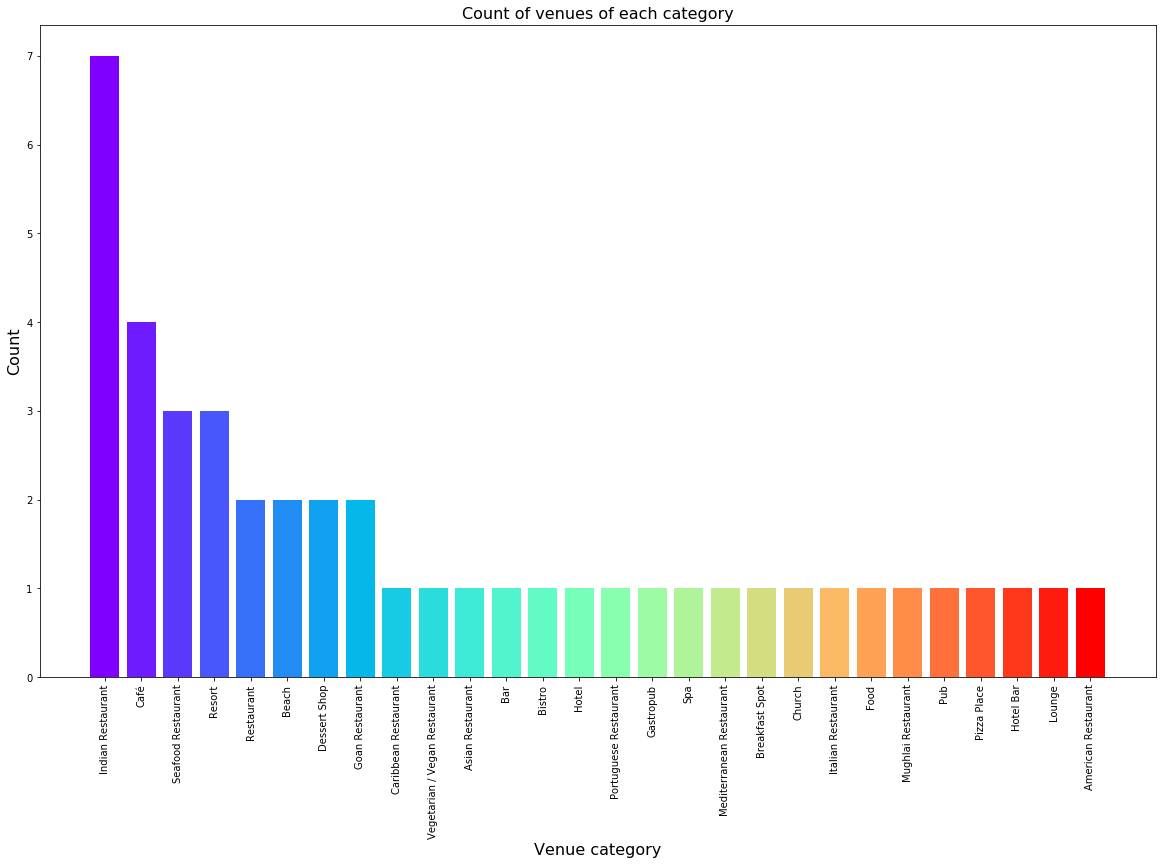

In [89]:
venue_distribution=selected_venues['categories'].value_counts()
colors =cm.rainbow(np.linspace(0,1,len(venue_distribution.index)))
plt.figure(figsize=(20,12))
plt.xticks(rotation=90)
plt.xlabel("Venue category", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Count of venues of each category",fontsize=16)
plt.bar(venue_distribution.index,venue_distribution.values,color=colors)

Text(0.5, 1.0, 'Count of venues with the given ratings')

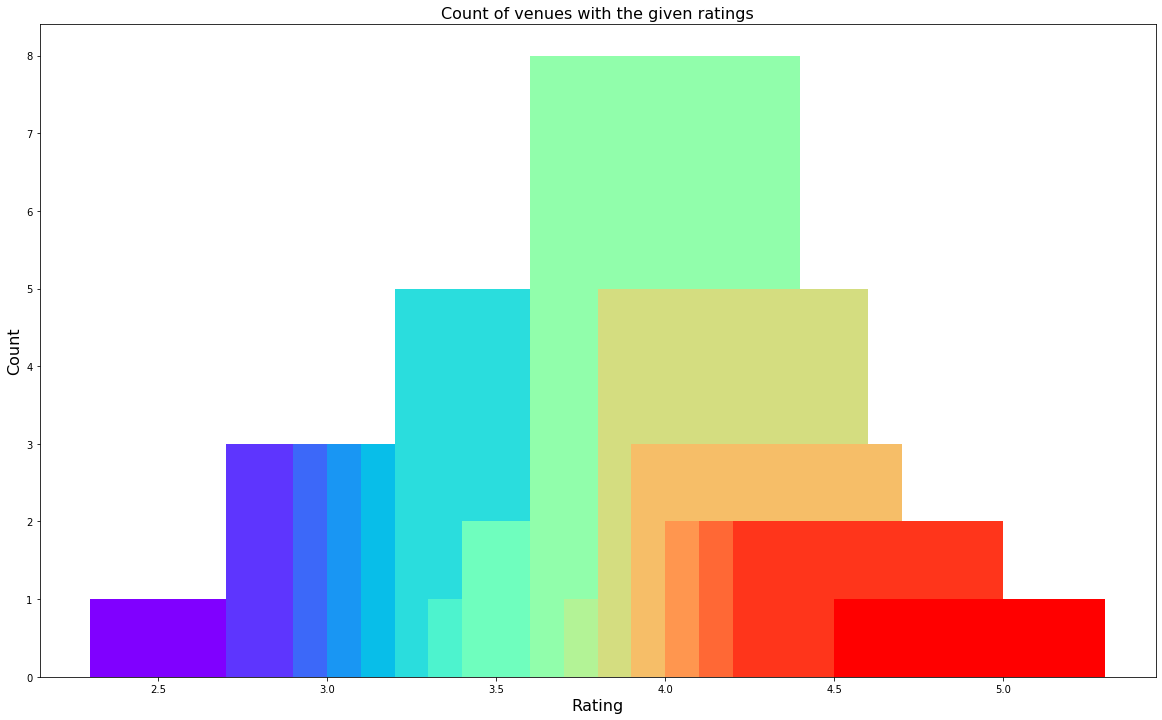

In [90]:
selected_venues['rating']=selected_venues['rating'].astype(float)
rating=selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize=(20,12))
plt.bar(rating.index,rating.values,color=cm.rainbow(np.linspace(0,1,len(rating.index))))
plt.xlabel("Rating",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.title("Count of venues with the given ratings",fontsize=16)

In [91]:
bins=[1.0,2.0,3.0,4.0,5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin']=pd.cut(selected_venues['rating'].astype(float),bins=bins,labels=labels,include_lowest=True)

In [92]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'blue', 'Very good': 'darkgreen'}
goa_map=folium.Map(location=[GOA_LATITUDE,GOA_LONGITUDE],zoom_start=13)
for name,address,latitude,longitude,rating_bin in zip(selected_venues['venue'],
                                                     selected_venues['address'],
                                                     selected_venues['latitude'],
                                                     selected_venues['longitude'],
                                                     selected_venues['rating_bin']):
    label='{},{}'.format(name,address)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        [latitude,longitude],
        icon=folium.Icon(color=color_map[rating_bin]),
        popup=label).add_to(goa_map)
goa_map.save("Venues Ratings.html")
goa_map

Text(0.5, 1.0, 'Count of venues with given average price')

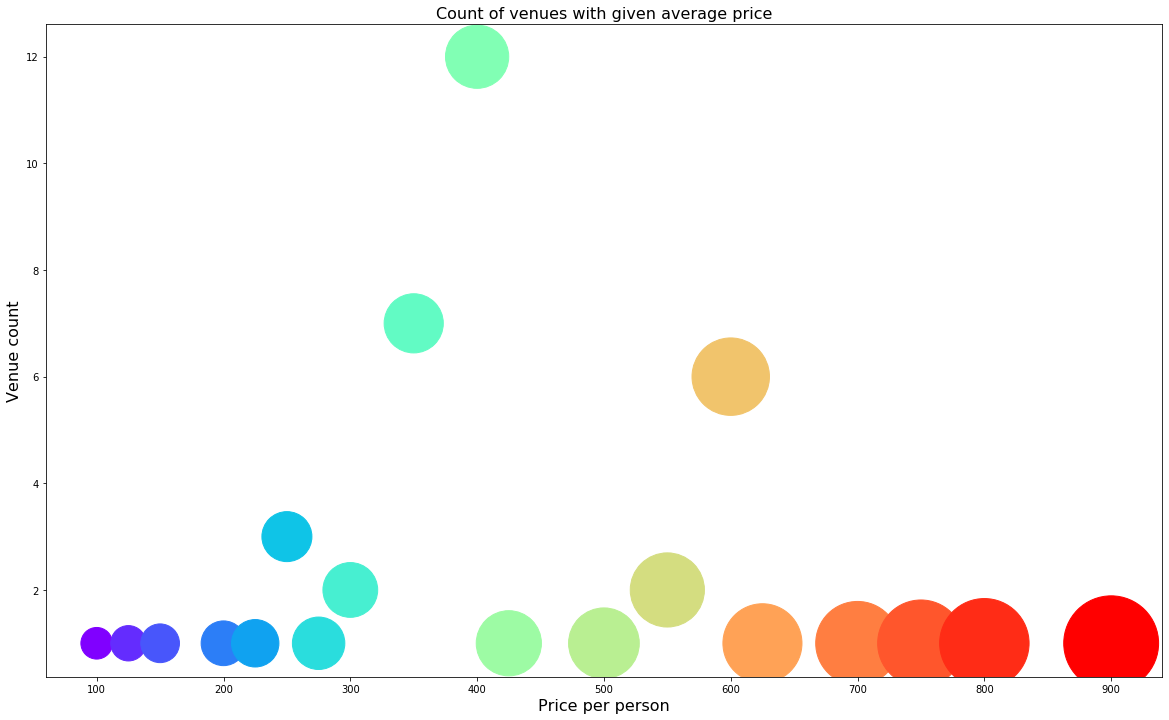

In [93]:
average_prices=selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize=(20,12))
plt.scatter(average_prices.index,
           average_prices.values,
           s=average_prices.index*10,
           c=cm.rainbow(np.linspace(0,1,len(average_prices.index))))
plt.xlabel("Price per person",fontsize=16)
plt.ylabel("Venue count",fontsize=16)
plt.title("Count of venues with given average price",fontsize=16)

In [94]:
color_map = {'1.0': 'blue', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

goa_map = folium.Map(location = [GOA_LATITUDE, GOA_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(goa_map)  

goa_map.save("Venues Prices.html")
goa_map

### Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [95]:
from sklearn.cluster import KMeans
no_of_cluster=2
clustering=selected_venues.drop(['venue','address','rating_bin','categories'],1)
Kmeans=KMeans(n_clusters=no_of_cluster,random_state=0).fit(clustering)
selected_venues.insert(0,'cluster_labels',Kmeans.labels_)


In [96]:
selected_venues.head(50)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0,Very good
1,0,Beach,Pedro's,15.2573,73.9197,3.0,3.6,"Benaulim Beach, Benaulim, Goa",350.0,Good
2,1,Food,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0,Very good
3,0,Vegetarian / Vegan Restaurant,Cafe Tato,15.2745,73.9593,3.0,3.3,"G-5, Apna Bazaar Complex, Margao, Goa",350.0,Good
4,0,Dessert Shop,Mog Cake Studio+ All Things Good,15.2767,73.9566,2.0,3.8,"Shop 3 & 4, Colaco Residency, Opposite Vibes M...",200.0,Good
5,0,Pizza Place,Pizza Hut,15.2852,73.9573,3.0,4.0,"Ground Floor, E Wing, Commercial Arcade, SGPDA...",300.0,Good
6,0,Seafood Restaurant,Zeebop,15.3207,73.8992,3.0,4.0,"Opposite Kenilworth Beach Resort, Utorda Beach...",400.0,Good
7,0,Indian Restaurant,Peppers,15.2726,73.9646,3.0,4.0,"15/604, Gold Road, Pajifond, Near Child Care S...",400.0,Good
8,0,Caribbean Restaurant,Portofino,15.2764,73.9178,3.0,3.6,"Ubis Pride, Colva Beach, Colva, Goa",400.0,Good
9,1,Gastropub,Praia Da Colva,15.2766,73.9173,4.0,3.3,"Colva Beach Road, Navelim, Colva, Goa",600.0,Good


In [97]:
goa_map=folium.Map(location=[GOA_LATITUDE,GOA_LONGITUDE],zoom_start=13)
color_map={0:'blue',1:'red'}

#add venues to maps
markers_colors=[]
for venue,address,cluster,latitude,longitude in zip(selected_venues['venue'],
                                                    selected_venues['address'],
                                                   selected_venues['cluster_labels'],
                                                   selected_venues['latitude'],
                                                   selected_venues['longitude']):
    label=folium.Popup(str(venue)+', '+str(address),parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius=5,
        popup=label,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.7).add_to(goa_map)
#add cluster center to map
for index,cluster in enumerate(Kmeans.cluster_centers_):
    latitude=cluster[0]
    longitude=cluster[1]
    label=folium.Popup("Cluster: "+str(index),parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius=5,
        popup=label,
        color=color_map[index],
        fill=True,
        fill_color=color_map[index],
        fill_opacity=0.7).add_to(goa_map)
goa_map.save("Venues Cluster.html")
goa_map

In [98]:
result=selected_venues[selected_venues['cluster_labels']==0]
print("Cluster 0")
result.head(50).reset_index(drop=True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Beach,Pedro's,15.2573,73.9197,3.0,3.6,"Benaulim Beach, Benaulim, Goa",350.0,Good
1,0,Vegetarian / Vegan Restaurant,Cafe Tato,15.2745,73.9593,3.0,3.3,"G-5, Apna Bazaar Complex, Margao, Goa",350.0,Good
2,0,Dessert Shop,Mog Cake Studio+ All Things Good,15.2767,73.9566,2.0,3.8,"Shop 3 & 4, Colaco Residency, Opposite Vibes M...",200.0,Good
3,0,Pizza Place,Pizza Hut,15.2852,73.9573,3.0,4.0,"Ground Floor, E Wing, Commercial Arcade, SGPDA...",300.0,Good
4,0,Seafood Restaurant,Zeebop,15.3207,73.8992,3.0,4.0,"Opposite Kenilworth Beach Resort, Utorda Beach...",400.0,Good
5,0,Indian Restaurant,Peppers,15.2726,73.9646,3.0,4.0,"15/604, Gold Road, Pajifond, Near Child Care S...",400.0,Good
6,0,Caribbean Restaurant,Portofino,15.2764,73.9178,3.0,3.6,"Ubis Pride, Colva Beach, Colva, Goa",400.0,Good
7,0,Goan Restaurant,Pedro's Bar And Restaurant,15.2573,73.9196,3.0,3.5,"Benaulim Beach, Benaulim, Goa",400.0,Good
8,0,Beach,Cocktails & Dreams,15.0112,74.0223,3.0,3.5,"1, Silver Stat, Palolem Beach, Palolem, Goa",400.0,Good
9,0,Spa,17th Avenue Cafe,15.2783,73.9284,3.0,3.5,"G6, Villa Nava, Westerlies Estate, Opposite Oc...",250.0,Good


In [64]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.81 and rating spread around 3.79


In [99]:
result=selected_venues[selected_venues['cluster_labels']==1]
print("Cluster 1")
result.head(50).reset_index(drop=True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0,Very good
1,1,Food,Nostalgia,15.3191,73.9839,4.0,4.2,"Margao Ponda Road, Raia, Margao, Goa",600.0,Very good
2,1,Gastropub,Praia Da Colva,15.2766,73.9173,4.0,3.3,"Colva Beach Road, Navelim, Colva, Goa",600.0,Good
3,1,Bistro,The Black Sheep Bistro,15.4962,73.8253,4.0,4.6,"Swami Vivekanand Road, Near ICICI Bank, Panaji...",750.0,Very good
4,1,Mediterranean Restaurant,Bay 15,15.4541,73.8287,4.0,4.9,"Odxel Beach, Dona Paula, Panaji, Goa",550.0,Very good
5,1,American Restaurant,Route 66,15.4978,73.8323,4.0,4.3,"4/232, Ward 4, Rua De Querem, Panaji, Goa",625.0,Very good
6,1,Goan Restaurant,The Fisherman's Wharf,15.4941,73.8197,4.0,4.6,"13/139, Campal, Tiswandi, Panaji, Goa",550.0,Very good
7,1,Bar,Café Mojo,15.4980,73.8248,4.0,4.0,"Menezes Branganza Road, Near Apple Corner, Pan...",700.0,Good
8,1,Resort,Agonda Sunset,15.0371,73.9894,4.0,3.1,"Agonda Beach, Palolem, Goa",600.0,Good
9,1,Lounge,Tataki Immersive Asian Dining,15.4991,73.8335,4.0,4.2,"Bento Miguel Building, D. Joao De Crasto Road,...",900.0,Very good


In [100]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 4.01
